In [1]:
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from typing import TypedDict, Literal
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

In [2]:
load_dotenv()

groq_key = os.getenv("groq_api_key")
os.environ["GROQ_API_KEY"] = groq_key

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0
)

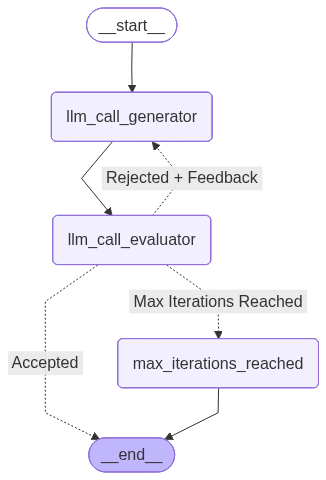

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01F\x00\x00\x01\xe0\x08\x02\x00\x00\x00V\xf0ST\x00\x00\x10\x00IDATx\x9c\xec\x9d\x05`\x13\xc9\x1a\xc7\'I\xbd\xa5\xa5\xa5@[(\x14w\x8a;EZ\\\x0f;\xf48\xe4\x1d\x1c\xee\xee\xee~\x1cz8\x87\xbb;\x87{q\n\x85\xe2-\xd2B\xdd\x93\xf7O\xb6\x84\x90&\xa1\x92\xb4\x9b\xcd\xf7;^\xdf\xee\xec\xee\xacd\xfe\xf3\xc9\xac\x98\xc9d2F\x10\x84P0c\x04A\x08\x08\x924A\x08\n\x924A\x08\n\x924A\x08\n\x924A\x08\n\x924A\x08\n\x92t*\xb8q*\xf8\xdd\xf3\xa8\xd8HYB\xbc,!N\xc6DL,\x16\xc9\x12\x98H\xc2\xa4R\x99H$b\x0c\x85b\x91H\xc6\xa4L*\x93\x97H$\xa2\x84D)\x8a1!\xc5\xff\xcbdff\xe2\x84\x04)j\x93\x88\x19\x96\xa0\x06l+\x96\x88e\xf8?\xf9\xd6\xf2:P\xb3L\xb1\x88\x1ba\xc4V\xa8U\xc6\xedB\xa4(\x90W\xc00\'_W\xc6\xb8qH\xac\x8f]\'&~?`\x89\x99\xfc\xd8\xcc-EN\xd9\xad\x8aW\xc9\xe2\x96\xdf\x86\x11BGD\xe3\xd2?\xe5\xd0\x9aw\xef_\xc4\xc4\xc7\xc9 KsKfa%\x81v\x12\xe3\xe5\x8b\xc4b\x96\x90(\x93\x98AI\xdf\xd5\x08\xa5A\x9eL&\x97\x9f\x18JN\x94kNl\xa62\x91 \xbf\xe6\x10\x1b\xb7\x15\xf4)\xff+\xe3:\x04\xf4\x05L,

In [3]:
# Graph state
class State(TypedDict):
    topic: str
    generate_prompt: str
    improve_prompt: str
    max_iterations: int
    joke: str
    feedback: str
    funny_or_not: str
    iteration: int


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"""Below is joke generated about {state['topic']} and the feedback is: {state['feedback']}
            Joke: {state['joke']}
            
            {state.get('improve_prompt', '')}

            Just return the improved joke, that's all"""
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}. {state.get('generate_prompt', '')}")
    return {"iteration": state.get("iteration", 0) + 1, "joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["iteration"] >= state["max_iterations"]:
        return "Max Iterations Reached"
    elif state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")

optimizer_builder.add_node("max_iterations_reached", lambda state: state)

optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {
        "Accepted": END,
        "Max Iterations Reached": "max_iterations_reached",
        "Rejected + Feedback": "llm_call_generator",
    },
)

optimizer_builder.add_edge("max_iterations_reached", END)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Save the workflow as image
optimizer_workflow.get_graph().draw_mermaid_png(output_file_path="optimizer_workflow_flow.png")

### Funny in first generation

In [4]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Cats", "generate_prompt": "Make it a pun", "improve_prompt": "Make it funnier", "max_iterations": 5})
print(state["joke"])

Why did the cat join a band? Because it wanted to be the purr-cussionist!


In [5]:
state

{'topic': 'Cats',
 'generate_prompt': 'Make it a pun',
 'improve_prompt': 'Make it funnier',
 'max_iterations': 5,
 'joke': 'Why did the cat join a band? Because it wanted to be the purr-cussionist!',
 'feedback': "This joke is funny because it's a clever play on words, using the cat's sound 'purr' to create a pun on the word 'percussionist'.",
 'funny_or_not': 'funny',
 'iteration': 1}

In [6]:
# Stream
for node in optimizer_workflow.stream({"topic": "Cats", "generate_prompt": "Make it a pun", "improve_prompt": "Make it funnier", "max_iterations": 5}):
    print(node)

{'llm_call_generator': {'iteration': 1, 'joke': 'Why did the cat join a band? Because it wanted to be the purr-cussionist!'}}
{'llm_call_evaluator': {'funny_or_not': 'funny', 'feedback': "This joke is funny because it's a clever play on words, using the cat's sound 'purr' to create a pun on the word 'percussionist'."}}


### Unfunny in first generation, improved after first feedback

In [7]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Cats", "generate_prompt": "Make it totally unfunny", "improve_prompt": "Make it funnier", "max_iterations": 5})
print(state["joke"])

Cats exist. They are a type of animal. But what's even weirder is that sometimes they're in rooms, and sometimes they're in charge – which is basically the same thing.


In [8]:
state

{'topic': 'Cats',
 'generate_prompt': 'Make it totally unfunny',
 'improve_prompt': 'Make it funnier',
 'max_iterations': 5,
 'joke': "Cats exist. They are a type of animal. But what's even weirder is that sometimes they're in rooms, and sometimes they're in charge – which is basically the same thing.",
 'feedback': "This joke is funny because it uses wordplay and clever observation to create humor. The punchline about cats being in charge is a clever twist on the common phrase 'in charge' and the fact that cats often act like they own the place.",
 'funny_or_not': 'funny',
 'iteration': 2}

In [9]:
# Stream
for node in optimizer_workflow.stream({"topic": "Cats", "generate_prompt": "Make it totally unfunny", "improve_prompt": "Make it funnier", "max_iterations": 5}):
    print(node)

{'llm_call_generator': {'iteration': 1, 'joke': 'Cats exist. They are a type of animal. Sometimes they are in rooms.'}}
{'llm_call_evaluator': {'funny_or_not': 'not funny', 'feedback': 'The joke is not funny because it is a straightforward statement of fact and lacks any unexpected twist, wordplay, or humor. To improve it, consider adding a punchline or a surprising connection between the setup and the conclusion.'}}
{'llm_call_generator': {'iteration': 2, 'joke': "Cats exist. They are a type of animal. But what's even weirder is that sometimes they're in rooms, and other times they're secretly ruling the internet from their invisible thrones."}}
{'llm_call_evaluator': {'funny_or_not': 'funny', 'feedback': 'This joke is funny because it starts with a mundane fact about cats and then escalates to an absurd and playful idea about them ruling the internet. The humor comes from the unexpected twist and the clever use of language.'}}


### Unfunny in first generation, no improvement after feedbacks

In [10]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Cats", "generate_prompt": "Make it totally unfunny", "improve_prompt": "Make it even less funny", "max_iterations": 5})
print(state["joke"])

Cats exist. They are a type of mammal. They have four legs and a tail. Sometimes they are in rooms. They breathe air. They are alive. They also have a heartbeat and their bodies are composed of cells. Additionally, they are subject to the laws of physics and are affected by gravity. Furthermore, their bodies are made up of organic molecules, and they are capable of experiencing physical sensations such as hunger and fatigue. They also have a circulatory system and a nervous system, and their movements are governed by the principles of biomechanics. Moreover, their existence is documented in various scientific and literary sources, and they are a part of the kingdom Animalia. This information can be found in numerous textbooks, academic journals, and online resources, including but not limited to Wikipedia, National Geographic, and the Encyclopedia Britannica. The classification and characteristics of cats are also described in detail by the International Union for Conservation of Natur

In [11]:
state

{'topic': 'Cats',
 'generate_prompt': 'Make it totally unfunny',
 'improve_prompt': 'Make it even less funny',
 'max_iterations': 5,
 'joke': 'Cats exist. They are a type of mammal. They have four legs and a tail. Sometimes they are in rooms. They breathe air. They are alive. They also have a heartbeat and their bodies are composed of cells. Additionally, they are subject to the laws of physics and are affected by gravity. Furthermore, their bodies are made up of organic molecules, and they are capable of experiencing physical sensations such as hunger and fatigue. They also have a circulatory system and a nervous system, and their movements are governed by the principles of biomechanics. Moreover, their existence is documented in various scientific and literary sources, and they are a part of the kingdom Animalia. This information can be found in numerous textbooks, academic journals, and online resources, including but not limited to Wikipedia, National Geographic, and the Encycloped

In [12]:
# Stream
for node in optimizer_workflow.stream({"topic": "Cats", "generate_prompt": "Make it totally unfunny", "improve_prompt": "Make it even less funny", "max_iterations": 5}):
    print(node)

{'llm_call_generator': {'iteration': 1, 'joke': 'Cats exist. They are a type of animal. Sometimes they are in rooms.'}}
{'llm_call_evaluator': {'funny_or_not': 'not funny', 'feedback': 'The joke is not funny because it is a straightforward statement of fact and lacks any unexpected twist, wordplay, or humor. To improve it, consider adding a punchline or a surprising connection between the setup and the conclusion.'}}
{'llm_call_generator': {'iteration': 2, 'joke': 'Cats exist. They are a type of mammal. They are often found on the planet Earth. Sometimes they are in rooms. Rooms are enclosed spaces.'}}
{'llm_call_evaluator': {'funny_or_not': 'not funny', 'feedback': 'This statement is more of a factual description about cats and their environment, rather than a joke. To make it funny, consider adding an unexpected twist, exaggeration, or wordplay.'}}
{'llm_call_generator': {'iteration': 3, 'joke': 'Cats are a species of animal that belongs to the family Felidae. They are a type of mamm